In [2]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib import finance

%matplotlib inline

# Loading and Exploring the Data

In [3]:
data = pd.read_csv('WIKI_20160608.csv', names=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close',
                                              'Volume', '7', '8', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C',
                                              'Adj-Vol'])

In [4]:
data.head(5)

,Ticker,Date,Open,High,Low,Close,Volume,7,8,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,38.440577,40.174379,38.316050,39.331425,3464400.0


Create a new dataframe with only the adjusted data, data, & ticker symbol.

In [5]:
dat = data[['Ticker', 'Date', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C', 'Adj-Vol']]

In [6]:
dat.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


In [7]:
dat.shape

(14150093, 7)

Create a dataframe for a specific ticker

In [8]:
agilent = dat[dat['Ticker'] == 'A']

In [9]:
agilent.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


Pretty straight forward to get a ticker specific set of data.  Below I will create a function to automate the process.

In [10]:
def tick_gettr(ticker):
    data = dat[dat['Ticker'] == ticker]
    return data

I will also create an array for all tickers in the dataset in case that comes in handy.

In [11]:
tickers = dat['Ticker']
tickers = tickers.unique()
len(tickers)

3179

Now I will get a ticker specific set of data to work with.

In [12]:
aapl = tick_gettr('AAPL')

## Basic Calculations

I need the components and then the look back period.

Also note that the calculations need to be made for the data historically, not just for the look back period (e.g. look back of 14 days gives us a value just for those 14 days.)  The look back period is how far back the function will look back to make the calculation.

**EXAMPLE:**

Using a lookback period of 14 days will gives us the 14 day calculation for RSI for the entire history of the data set, not just the last 14 days.  I will be able to look & see what the 14 day RSI was for June 25th, 2000 and for the most recent data point as well.

In [13]:
def rs(ticker, look_back):
    """
    A function to find the relative strength of a stock using a user specified
    look back period.
    """
    
    #Get the difference between consecutive adjusted closes.
    difference = ticker['Adj-C'].diff()
    difference = difference[1:]
    
    #Define & clean up the up sessions & down sessions.
    up, down = difference.copy(), difference.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    
    #Get the absolute value for the down sessions.
    down = down.abs()
    
    #Get the look_back mean for both up & down sessions.
    upper = up.rolling(window=look_back, center=False).mean()
    downer = down.rolling(window=look_back, center=False).mean()
        
    #Calculate the relative strength
    rs = upper / downer
    
    return rs

In [14]:
def rsi(ticker, look_back):
    """
    A function that determines the relative strength index of a specific stock.
    """
    
    #Get the relative strength.
    r_s = rs(ticker, look_back)
    #Calculate the RSI.
    rsi = 100.0 - 100.0 / (1.0 + r_s)

    return rsi.round(decimals=2)

The Python code to get the RS calculation was greatly informed from this StackOverflow answer:

http://stackoverflow.com/a/29400434/1094634

Also important to note, that some sources will calculate some element of the RSI differently.  Yahoo Finance & ThinkorSwim for instances calculate it the same (and differently from the above calculation) while Freestockcharts.com (Worden) calculates it the same way.

## Buy/Sell Rule:

I will begin with a simple buy/sell rule.  Buy @ the closing price when RSI < 30 & sell @ the closing price when RSI > 70.  The 30 & 70 thresholds are the traditional demarcation points for 'oversold' (<30) & 'overbought' (>70).  These thresholds are ripe for fine tuning.  Initially, I will be using the 14 day average.  The other average that I want to look at is the 9 day.  As with the oversold/overbought level, the optimal average needs to be tested/tuned as well.

Simply, what I want to know is if the RSI predicts higer prices from the buy point.  The actual price itself is not very important (at least in the initial stage.)  If the sell price is consistently higher than buy price, then I will interpret that as the RSI as having some predictive value (whether or not the RSI strategy is more profitable than simply buying the S&P 500 is a separate question.)


First, I will get Apples (AAPL) RSI using the 14 day average.

In [15]:
aapl_rsi = rsi(aapl, 14)

Now I want to add a new column to the dataset to include the RSI

In [16]:
aapl['RSI'] = aapl_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
aapl.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39644,AAPL,1980-12-12,0.436051,0.437871,0.436051,0.436051,117258400.0,NaN
39645,AAPL,1980-12-15,0.415273,0.415273,0.413301,0.413301,43971200.0,NaN
39646,AAPL,1980-12-16,0.384787,0.384787,0.382967,0.382967,26432000.0,NaN
39647,AAPL,1980-12-17,0.392370,0.394342,0.392370,0.392370,21610400.0,NaN
39648,AAPL,1980-12-18,0.403897,0.405717,0.403897,0.403897,18362400.0,NaN


Next I want to remove the first 14 columsn with NaNs for the RSI

In [18]:
aapl = aapl[14:]

In [19]:
aapl.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.50
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.50
39660,AAPL,1981-01-07,0.470177,0.470177,0.468357,0.468357,13921600.0,66.95
39661,AAPL,1981-01-08,0.460622,0.460622,0.458802,0.458802,9956800.0,63.18
39662,AAPL,1981-01-09,0.483524,0.485344,0.483524,0.483524,5376000.0,65.01


Now I want to create some more columns that will show the prices for days where the RSI is < 30 & > 70.

First I will create the Sell column with corresponding prices.

In [20]:
aapl['Sell Price'] = pd.Series(0, np.arange(8935))

In [21]:
aapl.ix[aapl.RSI > 70, 'Sell Price'] = aapl['Adj-C']

Next I will do the same for a Buy column.

In [22]:
aapl['Buy Price'] = pd.Series(0, np.arange(8935))

In [23]:
aapl.ix[aapl.RSI < 30, 'Buy Price'] = aapl['Adj-C']

I will also create several columns that represent holding periods of 1, 3, 5, & 10 days.  I think it will be beneficial to see whether or not arbitrary holding periods show better returns then the RSI > 70 sell point.  These holding periods can be played with and they are picked to represent the shorter term nature of this type of trade.

In [24]:
base = aapl.copy()
base = base['Adj-C']

day_1 = base.shift(-1)
day_3 = base.shift(-3)
day_5 = base.shift(-5)
day_10 = base.shift(-10)

In [25]:
aapl['Day 1'] = day_1
aapl['Day 3'] = day_3
aapl['Day 5'] = day_5
aapl['Day 10'] = day_10

In [26]:
aapl.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.50,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.50,NaN,NaN,0.468357,0.483524,0.462594,0.483524
39660,AAPL,1981-01-07,0.470177,0.470177,0.468357,0.468357,13921600.0,66.95,NaN,NaN,0.458802,0.479581,0.464565,0.492928
39661,AAPL,1981-01-08,0.460622,0.460622,0.458802,0.458802,9956800.0,63.18,NaN,NaN,0.483524,0.462594,0.473969,0.498539
39662,AAPL,1981-01-09,0.483524,0.485344,0.483524,0.483524,5376000.0,65.01,NaN,NaN,0.479581,0.464565,0.470177,0.496719


In [27]:
aapl.tail(1)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
48592,AAPL,2016-06-08,99.02,99.56,98.68,98.94,20689762.0,70.54,98.94,NaN,NaN,NaN,NaN,NaN


Now I have a complete dataset to begin working with.

# Analyzing the Data

### A simple and naive regression

First I am going to run a simple regression of the RSI column against the adjusted close column to see what that looks like.

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
aapl_prices = aapl[['Adj-C']]
aapl_rsi_d = aapl[['RSI']]

Splitting the training & test data.  I will do this manually since the historical order of the data is important.  I want to train the model on the older data and test it on the newer data to see if there is any predictive abilities.  A **caveat** here, however, this where many of these types of strategies and analytical approaches end up overfitting and producing models the have *disatsrous* results in the real world.

In [30]:
train_f = aapl_rsi_d[:7148]
train_p = aapl_prices[:7148]
test_f = aapl_rsi_d[7148:]
test_p = aapl_prices[7148:]

In [31]:
simple_linear = LinearRegression()
simple_linear.fit(train_f, train_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
predicted_price = simple_linear.predict(test_f)

In [33]:
simple_linear.score(test_f, test_p)

-4.4864101023722318

Not so good

Let's see what the RSS is.

In [34]:
np.sum((predicted_price - test_p) ** 2)

Adj-C    9.356749e+06
dtype: float64

Let's plot this out

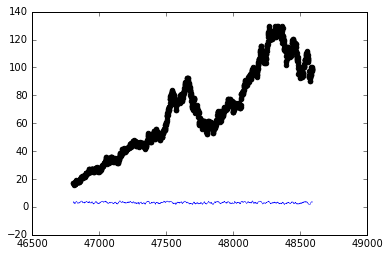

In [35]:
plt.scatter(test_f.index, test_p, color='black')
plt.plot(test_f.index, predicted_price, color='blue', linewidth=.5)

Obviously simply using the RSI values without any type of filter to predict prices is not effective.

Now I will use a number of features to see what the result is.

In [36]:
multi_naive_features = aapl[['Adj-O', 'Adj-H', 'Adj-L', 'Adj-Vol', 'RSI']]

multi_train_f = multi_naive_features[:7148]
multi_test_f = multi_naive_features[7148:]

In [37]:
multi_simple_linear = LinearRegression()
multi_simple_linear.fit(multi_train_f, train_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
multi_predicted_price = multi_simple_linear.predict(multi_test_f)

In [39]:
multi_simple_linear.score(multi_test_f, test_p)

0.99981783502231891

RSS

In [40]:
np.sum((multi_predicted_price - test_p) ** 2)

Adj-C    310.671642
dtype: float64

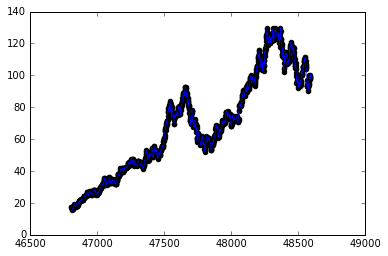

In [41]:
plt.scatter(multi_test_f.index, test_p, color='black')
plt.plot(multi_test_f.index, multi_predicted_price, color='blue', linewidth=.5)

These are some overfit results.  Now it's time to start thinking about how to use the RSI thresholds described above.

First I want to create another column that will show the post buy sell signal.  I want to keep a sell column as well, since it theoretically possible to use the overbought signal as signal to short.  Anecdotally the short signal using RSI hasn't not been considered very successful and any number of theories as to why have been floated, however, I have never tested this and want to keep that option open.

I will create another new column, 'Sell Signal Price', which will hold the closing price when the sell signal is generated.

In [51]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN,0.468357,0.483524,0.462594,0.483524


In [43]:
quick = aapl[['Adj-C', 'RSI', 'Sell Price', 'Buy Price']]

In [44]:
quick['Sell Signal Price'] = pd.Series(0, np.arange(8935))
quick.head()

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Adj-C,RSI,Sell Price,Buy Price,Sell Signal Price
39658,0.511886,64.50,NaN,NaN,NaN
39659,0.489136,64.50,NaN,NaN,NaN
39660,0.468357,66.95,NaN,NaN,NaN
39661,0.458802,63.18,NaN,NaN,NaN
39662,0.483524,65.01,NaN,NaN,NaN


In [45]:
quick = quick.fillna(0)
print quick.iloc[62]
print quick.iloc[9]

Adj-C                 0.399954
RSI                  71.410000
Sell Price            0.399954
Buy Price             0.000000
Sell Signal Price     0.000000
Name: 39720, dtype: float64
Adj-C                 0.470177
RSI                  29.550000
Sell Price            0.000000
Buy Price             0.470177
Sell Signal Price     0.000000
Name: 39667, dtype: float64


Now I will make a for loop to populate this new column with the relevant closing prices.

In [47]:
for price in quick.iterrows():
    if 0 < price[1][1] < 30:
        place = quick.query(price[0])
        p_start = quick.index.get_loc(place.name)
        temp_list = quick[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

In [49]:
print quick.iloc[9]

Adj-C                 0.470177
RSI                  29.550000
Sell Price            0.000000
Buy Price             0.470177
Sell Signal Price     0.399954
Name: 39667, dtype: float64


Now we have multiple columns with various price data.

In [50]:
quick.head()

,Adj-C,RSI,Sell Price,Buy Price,Sell Signal Price
39658,0.511886,64.50,0.0,0.0,0.0
39659,0.489136,64.50,0.0,0.0,0.0
39660,0.468357,66.95,0.0,0.0,0.0
39661,0.458802,63.18,0.0,0.0,0.0
39662,0.483524,65.01,0.0,0.0,0.0


In [56]:
# quick_300 = quick.iloc[:300]

In [62]:
# quick_multiple = quick_300['Adj-C'] * 10

In [69]:
# from matplotlib.axes import Axes

# plt.figure(figsize=(15,15))
# plt.scatter(quick_300.index, quick_multiple)
# # plt.yscale('log')
# plt.plot(quick_300.index, quick_300['RSI'], color='red', linewidth=1)

In [70]:
new_features = quick[['RSI', 'Buy Price']]
new_prices = quick[['Sell Signal Price']]

new_ftrain = new_features[:7148]
new_ptrain = new_prices[:7148]
new_ftest = new_features[7148:]
new_ptest = new_prices[7148:]

In [71]:
rsi_30_model = LinearRegression()
rsi_30_model.fit(new_ftrain, new_ptrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [73]:
new_30_predictions = rsi_30_model.predict(new_ftest)

In [74]:
rsi_30_model.score(new_ftest, new_ptest)

0.98512976758219584

In [75]:
np.sum((new_30_predictions - new_ptest) ** 2)

Sell Signal Price    11671.091729
dtype: float64

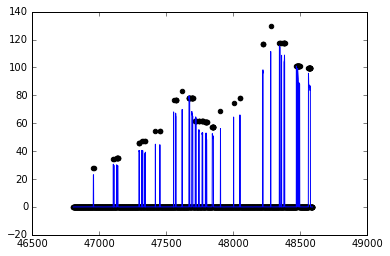

In [77]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, new_30_predictions, color='blue', linewidth=1)

### Using a decision tree regressor

In [78]:
from sklearn.tree import DecisionTreeRegressor

In [80]:
trereg_2 = DecisionTreeRegressor(max_depth=2)
trereg_5 = DecisionTreeRegressor(max_depth=5)

In [81]:
trereg_2.fit(new_ftrain, new_ptrain)
trereg_5.fit(new_ftrain, new_ptrain)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [83]:
tree_2_predict = trereg_2.predict(new_ftest)

In [84]:
tree_5_predict = trereg_5.predict(new_ftest)

In [85]:
trereg_2.score(new_ftest, new_ptest)

0.29166041143263166

In [86]:
trereg_5.score(new_ftest, new_ptest)

0.27080168559486484

In [117]:
rsi_30_actual = new_ptest.as_matrix(columns=['Sell Signal Price'])
rsi_30_actual =  rsi_30_actual.reshape((1787,))

In [119]:
np.sum((tree_2_predict - rsi_30_actual) ** 2)

555949.3679156045

In [120]:
np.sum((tree_5_predict - rsi_30_actual) ** 2)

572320.60514729063

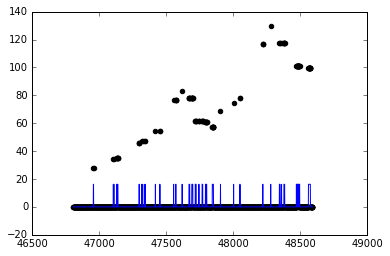

In [121]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree_2_predict, color='blue', linewidth=1)

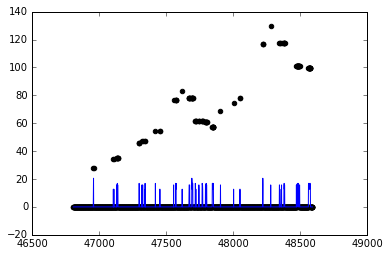

In [122]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree_5_predict, color='blue', linewidth=1)

In [127]:
trereg_20 = DecisionTreeRegressor(max_depth=20)
trereg_20.fit(new_ftrain, new_ptrain)
tree_20_predict = trereg_20.predict(new_ftest)

In [128]:
trereg_20.score(new_ftest, new_ptest)

0.28727977271820282

In [129]:
np.sum((tree_20_predict - rsi_30_actual) ** 2)

559387.56812869583

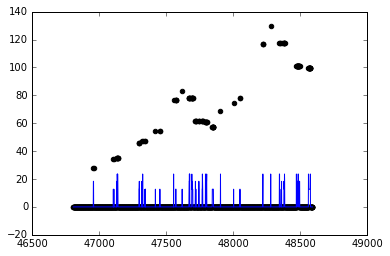

In [130]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree_20_predict, color='blue', linewidth=1)

## Using holding periods

In order to avoid training each possibilty by hand, I'll now write a function to automate the process.  This idea is inspired by University of Washingtons Linear Regression course on Coursera.

In [155]:
periods = ['Day 1', 'Day 3', 'Day 5', 'Day 10']
hold_features = ['RSI', 'Buy Price']

quick = aapl[['RSI', 'Buy Price', 'Day 1', 'Day 3', 'Day 5', 'Day 10']]

In [161]:
def predictor(data, periods, features):
    """
    A function to automate the modeling for linear regression.  The data param is the data set
    that the models will be trained on and predictions made from.  The periods param will contain a list of
    the columns that will contain the relevant price data.
    """
    
    #Create and prepare the feature data set.
    features = data[features]
    features = features.fillna(0)
#     features = features.reshape((8935,1))
    train_f = features[:7148]
    test_f = features[7148:]
    
    for i in periods:
        #Create and prepare the price data set.
        prices = data[i]
        prices = prices.fillna(0)
        prices = prices.reshape((8935,1))
        
        train_p = prices[:7148]
        test_p = prices[7148:]
        
        #Train model & make predictions.
        model = LinearRegression()
        model.fit(train_f, train_p)
        predictions = model.predict(test_f)
        
        #Get RSS.
        rss = np.sum((predictions - test_p) ** 2)
        
        #Model score.
        score = model.score(test_f, test_p)
        
        print "The score, {}, and RSS, {}, of the model for {}".format(score, rss, i)
    

In [162]:
predictor(quick, periods, hold_features)

The score, -4.05448784097, and RSS, 8630669.29191, of the model for Day 1
The score, -4.04152152132, and RSS, 8629283.47635, of the model for Day 3
The score, -4.03151988386, and RSS, 8632681.31584, of the model for Day 5
The score, -4.00502160549, and RSS, 8636099.24864, of the model for Day 10
